In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
words = open('names.txt', 'r').read().splitlines()
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [30]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [31]:
# build the dataset

block_size = 3

def build_dataset(words, block_size):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [32]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size=block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size)
Xte, Yte = build_dataset(words[n2:], block_size=block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [33]:
# MLP
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size) ** 0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b2, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
  p.requires_grad = True

12124


tensor(-0.0095) tensor(0.9996)
tensor(-0.0110) tensor(10.1819)


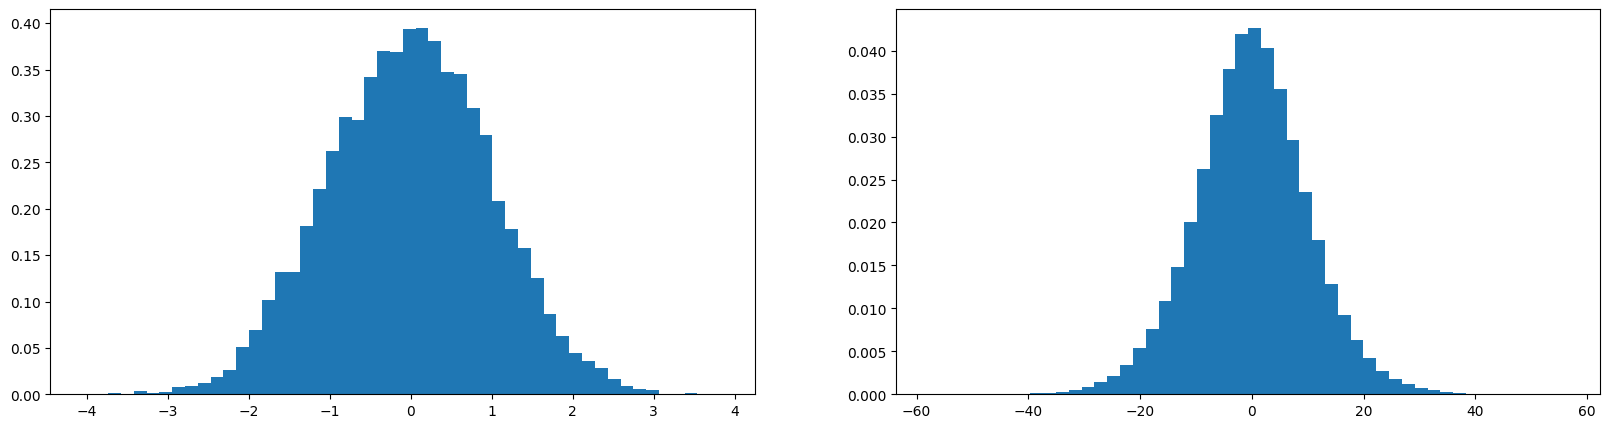

In [34]:
x = torch.randn(1000, 10)
# w = torch.randn(10, 200)
w = torch.randn(10, 200) * (10 ** 0.5)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [35]:
# (torch.randn(1000000)).std()
(torch.randn(1000000) * 0.7).std()

tensor(0.7001)

In [36]:
n_embd * block_size

30

In [37]:
(5 / 3) / (30 ** 0.5)

0.3042903097250923

In [38]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # break

      0/ 200000: 3.3239
  10000/ 200000: 2.0356
  20000/ 200000: 2.5568
  30000/ 200000: 1.9879
  40000/ 200000: 2.2290
  50000/ 200000: 1.8869
  60000/ 200000: 2.0665
  70000/ 200000: 2.3314
  80000/ 200000: 2.3166
  90000/ 200000: 2.0408
 100000/ 200000: 2.3705
 110000/ 200000: 2.3430
 120000/ 200000: 1.6249
 130000/ 200000: 1.9628
 140000/ 200000: 2.2123
 150000/ 200000: 1.9918
 160000/ 200000: 2.1337
 170000/ 200000: 2.4861
 180000/ 200000: 2.0826
 190000/ 200000: 2.2001


In [39]:
hpreact.shape

torch.Size([32, 200])

In [40]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [41]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

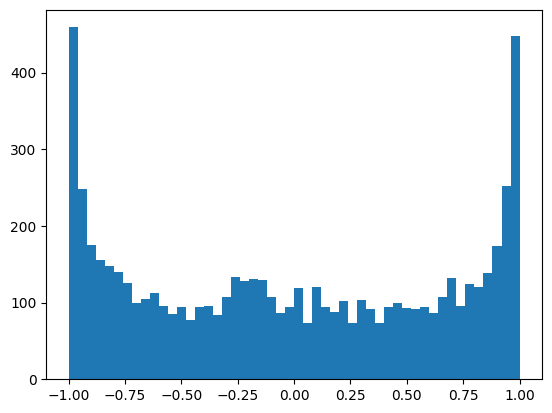

In [42]:
plt.hist(h.view(-1).tolist(), 50);

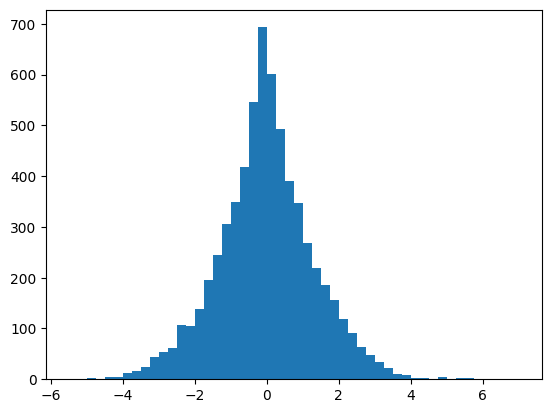

In [43]:
plt.hist(hpreact.view(-1).tolist(), 50);

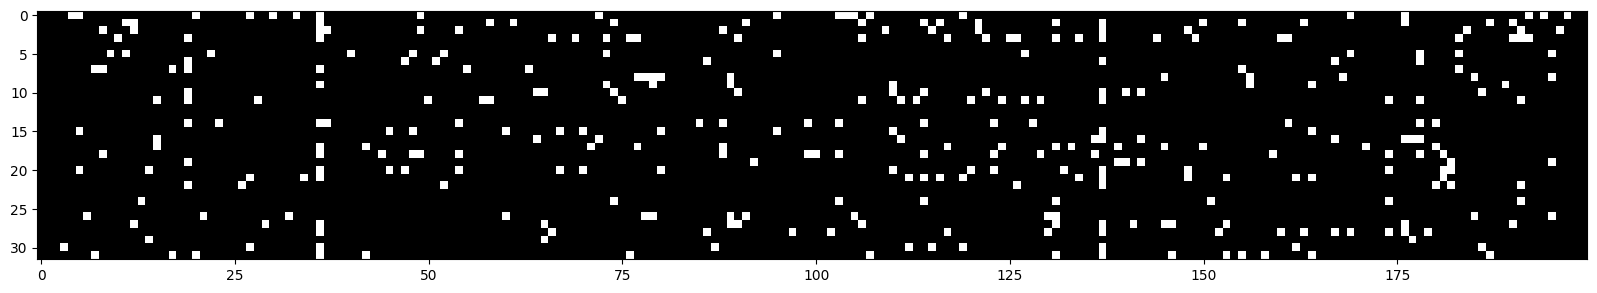

In [44]:
# good that there is no column of white
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest');

In [45]:
# logits[0]

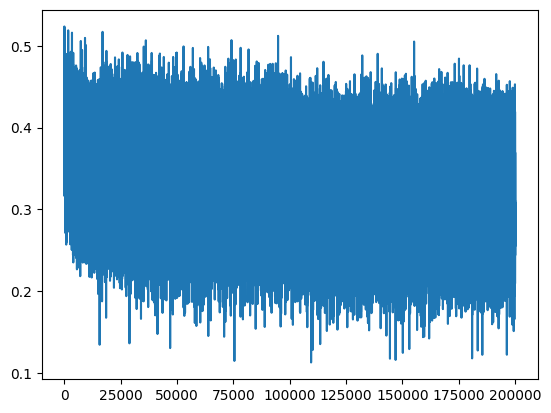

In [46]:
plt.plot(lossi);

In [47]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [48]:
bnmean

tensor([[-2.3380e+00,  5.5537e-01, -1.1010e+00,  1.3146e+00,  9.3893e-01,
          8.1550e-01,  1.8445e+00, -1.8306e+00,  7.2714e-01,  8.4476e-01,
         -1.7701e+00, -2.3960e+00, -5.3662e-01, -4.6545e-01,  6.3703e-02,
         -6.2483e-01,  1.3945e+00, -2.2999e+00, -4.6504e-02,  1.6556e+00,
         -3.4062e-01,  2.2021e-01,  2.2288e-01,  4.6107e-01,  1.2560e+00,
          1.3711e+00,  1.1773e+00,  4.2643e-01,  3.9249e-01,  1.6661e+00,
         -9.4092e-02, -1.1780e+00, -4.1826e-01, -6.3576e-01, -5.3490e-01,
         -1.6716e+00, -2.6276e+00,  1.7334e-01,  1.3297e-01,  5.8530e-01,
         -3.2139e-01, -1.2093e+00, -4.6517e-01,  2.1397e-01,  7.7695e-01,
          7.8225e-01,  2.0191e+00, -5.7977e-01,  1.7677e+00,  1.1049e+00,
          1.2861e+00, -5.3959e-01,  1.5705e+00,  5.5938e-01,  7.1843e-01,
         -1.7017e+00,  1.9302e-01,  3.0934e-01,  9.9526e-01, -1.0805e+00,
         -5.8754e-01,  7.8573e-01,  3.9990e-01,  2.5045e-01,  1.7250e+00,
          1.3600e+00, -1.6308e+00,  2.

In [49]:
bnmean_running

tensor([[-2.3512,  0.5585, -1.0894,  1.3186,  0.9479,  0.8054,  1.8336, -1.8403,
          0.7234,  0.8290, -1.7798, -2.3889, -0.5386, -0.4785,  0.0654, -0.6133,
          1.3964, -2.3138, -0.0710,  1.6362, -0.3275,  0.2421,  0.2244,  0.4633,
          1.2566,  1.3743,  1.1842,  0.4286,  0.3899,  1.6639, -0.1108, -1.1740,
         -0.4182, -0.6386, -0.5288, -1.6691, -2.6234,  0.1676,  0.1483,  0.5973,
         -0.3243, -1.2305, -0.4620,  0.2167,  0.7887,  0.7882,  2.0188, -0.5840,
          1.7518,  1.0938,  1.2795, -0.5486,  1.5565,  0.5511,  0.7068, -1.7003,
          0.1909,  0.3080,  1.0001, -1.0804, -0.6034,  0.7700,  0.3923,  0.2444,
          1.7210,  1.3461, -1.6405,  2.3671, -0.8293, -0.0056,  0.4570, -0.1060,
          1.1975, -1.5142, -3.2022,  0.1573,  0.6195, -0.0158,  0.6368,  0.6912,
         -0.0061,  1.3144,  1.6557,  0.4976, -0.1653,  0.1882, -1.8448,  0.2828,
         -0.2021, -0.2560, -0.5759,  1.5365, -0.5834, -1.2916, -0.7057,  0.3644,
         -0.3186,  0.4776,  

In [50]:
# bnstd

In [51]:
# bnstd_running

In [52]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

In [53]:
split_loss('train')
split_loss('test')

train 2.067155361175537
test 2.1065657138824463


In [54]:
# sample from the model
g = torch.Generator().manual_seed(214783647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # forward pass the neural net
        context_tensor = torch.tensor([context])  # Convert context to a tensor of shape (1, block_size)
        emb = C[context_tensor]  # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # Compute hidden layer
        logits = h @ W2 + b2  # Compute logits
        probs = F.softmax(logits, dim=1)  # Compute probabilities
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

menrexdulissiahshb.
srvy.
mazesiamsiahanzellid.
britsumasrishbnnivessstts.
piveah.
brayshtukiyah.
franzsxayahmidarik.
saddh.
miyah.
sulylisamaidhlyliersemmikalissammariamarifergiyzahsiadamaisleyah.
vizellnnishyaltxpedd.
vekahlanifranshtrl.
helmyshettll.
saidarifunesskubiersofertph.
brienc.
saidin.
stavahmiliyannistin.
zaypirizabrymudith.
sabiresdianayaceslyndhleighdya.
tebbyashmishjaqahmfasdie.


Summary

In [58]:
# Let's train a deeper neural network

class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in ** 0.5)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out =  x @ self.weight
    if self.bias is not None:
      self.out += self.bias

    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    # parameters (trained wit backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [59]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p -= lr * p.grad

  # tract stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  break